In [1]:
import sys
import os
import numpy as np
import pandas as pd

from scipy.stats import spearmanr

import matplotlib.pyplot as plt


In [2]:
#Read gene lengths and no. of exons

genes_bed_file = '/home/drk/seqnn/data/models/v2/f0c0/testg-0/genes.bed'

gene_lengths = {}
gene_exons = {}

#Loop over lines in bed file (exon-level)
for line in open(genes_bed_file) :

    a = line.rstrip().split('\t')

    gene_id = a[3].split(".")[0]
    gene_seg_len = int(a[2]) - int(a[1])

    #Accumulate gene lengths and number of exons
    gene_lengths[gene_id] = gene_lengths.get(gene_id,0) + gene_seg_len
    gene_exons[gene_id] = gene_exons.get(gene_id,0) + 1


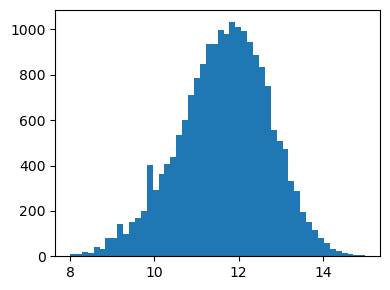

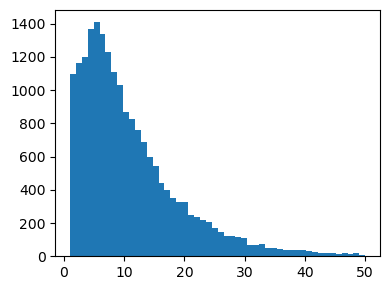

In [3]:
#Plot distribution of gene lengths

#Log space
f = plt.figure(figsize=(4, 3))

plt.hist(np.log2(list(gene_lengths.values())), range=(8, 15), bins=50)
plt.tight_layout()

plt.show()

#Plot distribution of exon counts

#Linear space
f = plt.figure(figsize=(4, 3))

plt.hist(list(gene_exons.values()), range=(1, 50), bins=50)
plt.tight_layout()

plt.show()


In [4]:
#Load measured / predicted coverages and calculate break-down of held-out gene-level performance

length_bins = [
    [7, 10],
    [10, 11],
    [11, 12],
    [12, 13],
    [13, 16],
]

exon_bins = [
    [0, 5],
    [5, 10],
    [10, 20],
    [20, 30],
    [30, 50],
]

fold_index = [0, 1, 2, 3]

r_vals_lens = []
r_vals_exons = []

n_samples_lens = []
n_samples_exons = []

#Loop over folds
for fold_ix in fold_index :

    print("fold = " + str(fold_ix))
    
    r_vals_lens_fold = []
    r_vals_exons_fold = []
    
    n_samples_lens_fold = []
    n_samples_exons_fold = []
    
    #Load predictions
    df_pred = pd.read_csv("test_apa/f" + str(fold_ix) + "c0/testg_no_unclip_rna_fix-0/gene_preds.tsv", sep='\t')
    df_pred = df_pred.rename(columns={'Unnamed: 0' : 'gene_id'})

    #Load targets
    df_true = pd.read_csv("test_apa/f" + str(fold_ix) + "c0/testg_no_unclip_rna_fix-0/gene_targets.tsv", sep='\t')
    df_true = df_true.rename(columns={'Unnamed: 0' : 'gene_id'})
    
    #Use all targets
    target_cols = df_pred.columns.values.tolist()[1:]
    
    #Append lengths and exon counts
    lens = []
    exons = []
    for _, row in df_pred.iterrows() :
        
        lens.append(gene_lengths[row['gene_id'].split(".")[0]])
        exons.append(gene_exons[row['gene_id'].split(".")[0]])
    
    df_pred['gene_len'] = lens
    df_pred['n_exons'] = exons
    
    df_true['gene_len'] = lens
    df_true['n_exons'] = exons
    
    df_pred = df_pred[['gene_id', 'gene_len', 'n_exons'] + target_cols].copy()
    df_true = df_true[['gene_id', 'gene_len', 'n_exons'] + target_cols].copy()
    
    print("df_pred.shape = " + str(df_pred.shape))
    print("df_true.shape = " + str(df_true.shape))
    
    lens = np.array(df_pred['gene_len'].values, dtype='float32')
    exons = np.array(df_pred['n_exons'].values, dtype='float32')
    
    y_pred = np.array(df_pred[target_cols].values, dtype='float32')
    y_true = np.array(df_true[target_cols].values, dtype='float32')
    
    num_targets_strand = y_pred.shape[1]
    
    print("num_targets_strand = " + str(num_targets_strand))
    
    #Loop over length bins
    for len_i, [len_lo, len_hi] in enumerate(length_bins) :
        
        print(" - length range = " + str([len_lo, len_hi]))
        
        n = np.nonzero((np.log2(lens) >= len_lo) & (np.log2(lens) < len_hi))[0].shape[0]
        n_samples_lens_fold.append(n)
        
        r_val_len = []
        
        #Loop over targets
        for ti in range(num_targets_strand) : 
            
            y_t = y_true[:, ti]
            y_p = y_pred[:, ti]
            
            #Calculate coverage pearson correlation
            keep_ixs = np.nonzero((np.log2(lens) >= len_lo) & (np.log2(lens) < len_hi))[0]
            
            y_t = y_t[keep_ixs]
            y_p = y_p[keep_ixs]
            
            r_val_len.append(spearmanr(y_p, y_t)[0])
        
        r_vals_lens_fold.append(r_val_len)
    
    #Loop over exon count bins
    for ex_i, [ex_lo, ex_hi] in enumerate(exon_bins) :
        
        print(" - exon count range = " + str([ex_lo, ex_hi]))
        
        n = np.nonzero((exons >= ex_lo) & (exons < ex_hi))[0].shape[0]
        n_samples_exons_fold.append(n)
        
        r_val_exon = []
        
        #Loop over targets
        for ti in range(num_targets_strand) : 
            
            y_t = y_true[:, ti]
            y_p = y_pred[:, ti]
            
            #Calculate coverage pearson correlation
            keep_ixs = np.nonzero((exons >= ex_lo) & (exons < ex_hi))[0]
            
            y_t = y_t[keep_ixs]
            y_p = y_p[keep_ixs]
            
            r_val_exon.append(spearmanr(y_p, y_t)[0])
        
        r_vals_exons_fold.append(r_val_exon)
    
    r_vals_lens.append(r_vals_lens_fold)
    r_vals_exons.append(r_vals_exons_fold)
    n_samples_lens.append(n_samples_lens_fold)
    n_samples_exons.append(n_samples_exons_fold)

r_vals_len = np.array(r_vals_lens, dtype='float32')
r_vals_exon = np.array(r_vals_exons, dtype='float32')
n_samples_len = np.array(n_samples_lens, dtype='float32')
n_samples_exon = np.array(n_samples_exons, dtype='float32')

print("r_vals_len.shape = " + str(r_vals_len.shape))
print("r_vals_exon.shape = " + str(r_vals_exon.shape))
print("n_samples_len.shape = " + str(n_samples_len.shape))
print("n_samples_exon.shape = " + str(n_samples_exon.shape))


fold = 0
df_pred.shape = (2487, 958)
df_true.shape = (2487, 958)
num_targets_strand = 955
 - length range = [7, 10]
 - length range = [10, 11]
 - length range = [11, 12]
 - length range = [12, 13]
 - length range = [13, 16]
 - exon count range = [0, 5]
 - exon count range = [5, 10]
 - exon count range = [10, 20]
 - exon count range = [20, 30]
 - exon count range = [30, 50]
fold = 1
df_pred.shape = (3033, 958)
df_true.shape = (3033, 958)
num_targets_strand = 955
 - length range = [7, 10]
 - length range = [10, 11]
 - length range = [11, 12]
 - length range = [12, 13]
 - length range = [13, 16]
 - exon count range = [0, 5]
 - exon count range = [5, 10]
 - exon count range = [10, 20]
 - exon count range = [20, 30]
 - exon count range = [30, 50]
fold = 2
df_pred.shape = (2054, 958)
df_true.shape = (2054, 958)
num_targets_strand = 955
 - length range = [7, 10]
 - length range = [10, 11]
 - length range = [11, 12]
 - length range = [12, 13]
 - length range = [13, 16]
 - exon count range = [0

In [5]:
#Print summary statistics of chosen boundaries

print("Fraction of data / bin (length) = " + str(np.round(np.sum(n_samples_len, axis=0) / np.sum(n_samples_len), 3)))
print("Fraction of data / bin (exon counts) = " + str(np.round(np.sum(n_samples_exon, axis=0) / np.sum(n_samples_exon), 3)))


Fraction of data / bin (length) = [0.084 0.187 0.337 0.294 0.098]
Fraction of data / bin (exon counts) = [0.244 0.318 0.301 0.097 0.04 ]


In [6]:
#Load cached GTEx results

r_vals_len_gtex = np.load('expr_correlation_by_length_gtex.npy')
r_vals_exon_gtex = np.load('expr_correlation_by_exons_gtex.npy')


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


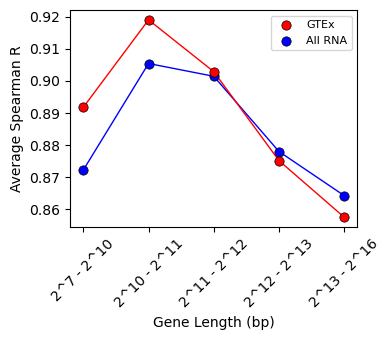

In [7]:
#Plot test set prediction performance as a function of gene length

f = plt.figure(figsize=(4, 3.5))

length_strs = [
    "2^" + str(len_lo) + " - 2^" + str(len_hi)
    for [len_lo, len_hi] in length_bins
]

x_len = np.arange(len(length_strs))

plt.plot(x_len, np.mean(r_vals_len_gtex, axis=(0, 2)), color='red', linewidth=1, zorder=-1)
plt.scatter(x_len, np.mean(r_vals_len_gtex, axis=(0, 2)), s=45, c='red', edgecolor='black', linewidth=0.5, zorder=2, label='GTEx')

plt.plot(x_len, np.mean(r_vals_len, axis=(0, 2)), color='blue', linewidth=1, zorder=-2)
plt.scatter(x_len, np.mean(r_vals_len, axis=(0, 2)), s=45, c='blue', edgecolor='black', linewidth=0.5, zorder=1, label='All RNA')

plt.xlabel("Gene Length (bp)", fontsize=10)
plt.ylabel("Average Spearman R", fontsize=10)

plt.xticks(x_len, length_strs, fontsize=10, rotation=45)
plt.yticks(fontsize=10)

plt.legend(fontsize=8)

plt.tight_layout()

plt.savefig("borzoi_v2_expr_correlation_by_length.png", dpi=300)
plt.savefig("borzoi_v2_expr_correlation_by_length.eps")

plt.show()


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


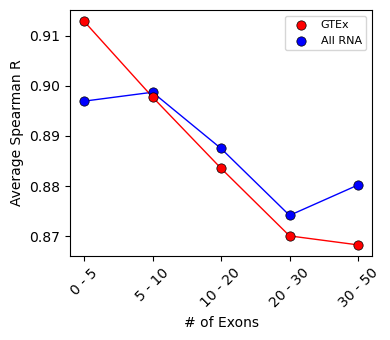

In [8]:
#Plot test set prediction performance as a function of number of exons

f = plt.figure(figsize=(4, 3.5))

exon_strs = [
    str(ex_lo) + " - " + str(ex_hi)
    for [ex_lo, ex_hi] in exon_bins
]

x_exon = np.arange(len(exon_strs))

plt.plot(x_exon, np.mean(r_vals_exon_gtex, axis=(0, 2)), color='red', linewidth=1, zorder=-1)
plt.scatter(x_exon, np.mean(r_vals_exon_gtex, axis=(0, 2)), s=45, c='red', edgecolor='black', linewidth=0.5, zorder=2, label='GTEx')

plt.plot(x_exon, np.mean(r_vals_exon, axis=(0, 2)), color='blue', linewidth=1, zorder=-2)
plt.scatter(x_exon, np.mean(r_vals_exon, axis=(0, 2)), s=45, c='blue', edgecolor='black', linewidth=0.5, zorder=1, label='All RNA')

plt.xlabel("# of Exons", fontsize=10)
plt.ylabel("Average Spearman R", fontsize=10)

plt.xticks(x_exon, exon_strs, fontsize=10, rotation=45)
plt.yticks(fontsize=10)

plt.legend(fontsize=8)

plt.tight_layout()

plt.savefig("borzoi_v2_expr_correlation_by_exon.png", dpi=300)
plt.savefig("borzoi_v2_expr_correlation_by_exon.eps")

plt.show()
